# Entrenamiento del modelo creado en U3.2.1 con validación usando GPU en Google Colaboratory 

Partiendo de las tareas realizadas en U3.2.1, donde se creó un modelo preliminar y se entrenó sin realizar validación, y de U3.2.2, donde se implementó Transfer Learning con InceptionV3 y se obtuvo un modelo con overfitting pese a los esfuerzos; se decidió volver a entrenar el modelo creado en U3.2.1, $\textbf{realizando validación y utilizando la GPU de Google Colaboratory}$ (este notebook fue ejecutado en [Colab](https://colab.research.google.com/notebooks/welcome.ipynb) para realizar el entrenamiento)

# Contenido

####  1. Importación de librerías y cargue del dataset RPC
####  2. Creación del modelo CNN
####  3. Entrenamiento del modelo CNN con validación en Colab

 ## 1. Importación de librerías y cargue del dataset RPC

A continuación, se cargan algunas de las librerías necesarias para completar esta tarea:

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
%matplotlib inline

Se lee el archivo json que contiene información del dataset y se dividen en datasets de imágenes y etiquetas.

In [4]:
data_df = pd.read_json('./data/instances_train2019.json', lines=True)
categories = data_df['categories'][0]
categories = df = pd.DataFrame.from_dict(categories, orient='columns')
annotations = data_df['annotations'][0]
annotations = df = pd.DataFrame.from_dict(annotations, orient='columns')
images = data_df['images'][0]
images = df = pd.DataFrame.from_dict(images, orient='columns')

annot_x_categ = pd.merge(annotations, categories, how='left', left_on=['category_id'], right_on=['id'])
y_names = annot_x_categ['supercategory'].unique().tolist()
annot_x_categ_file_names = pd.merge(annot_x_categ, images, how='left', left_on=['image_id'], right_on=['id'])
y_data = np.array(annot_x_categ_file_names['supercategory'].values)
X_data = np.array(annot_x_categ_file_names['file_name'].values)
num_classes = len(y_names)

X_data.shape, y_data.shape, num_classes

((53739,), (53739,), 17)

Se divide el conjunto de datos entre train y test.

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((42991,), (10748,), (42991,), (10748,))

Se crea un dataframe con el conjunto de datos de train.

In [0]:
columns = ['filename','class']

df_train = pd.DataFrame(columns=columns)
df_train['filename'] = X_train.astype(str)
df_train['class'] = y_train.astype(str)

df_test = pd.DataFrame(columns=columns)
df_test['filename'] = X_test.astype(str)
df_test['class'] = y_test.astype(str)

Luego de esto, se utiliza $\textbf{ImageDataGenerator}$ para normalizar las imágenes y realizar un split de las imágenes del train, dejando un 25% para validación. Se define un tamaño de batch de 20 imágenes y un tamaño de imágen de 200x200. Finalmente, se definen las funciones con las cuales se cargarán las imágenes por lotes para train, validation y test.

In [0]:
train_datagen = ImageDataGenerator(rescale=1./255, fill_mode='nearest', validation_split=0.25)
batch_size = 20
img_size = 200

train_generator_fn = lambda: train_datagen.flow_from_dataframe(
        df_train,  
        directory="./data/train2019/", 
        x_col='filename', 
        y_col='class',
        subset="training",
        target_size=(img_size, img_size),  
        batch_size=batch_size,
        interpolation = 'nearest',
        class_mode='categorical') 

valid_generator_fn = lambda: train_datagen.flow_from_dataframe(
        df_train,  
        directory="./data/train2019/", 
        x_col='filename', 
        y_col='class',
        subset="validation",
        target_size=(img_size, img_size),  
        batch_size=batch_size,
        interpolation = 'nearest',
        class_mode='categorical') 

test_datagen=ImageDataGenerator(rescale=1./255, fill_mode='nearest')

test_generator_fn = lambda: test_datagen.flow_from_dataframe(
        df_test,  
        directory="./data/train2019/", 
        x_col='filename', 
        y_col='class',
        target_size=(img_size, img_size),  
        batch_size=batch_size,
        interpolation = 'nearest',
        class_mode='categorical') 

También, se definen una función que nos servirán para ver graficamente los resultados del entrenamiento. El parámentro de entrada es un modelo recién entrenado. La función realiza un gráfico de $\textbf{accuracy}$ y $\textbf{accuracy_validation}$ contra $\textbf{épocas}$ y otro de $\textbf{loss}$ y $\textbf{loss_validation}$ contra las $\textbf{épocas}$.

In [0]:
def plot_metrics_model(model):
    plt.figure(figsize=(20,5))
    plt.subplot(1,2,1)
    plt.plot(model.history.history["acc"], label="acc")
    plt.plot(model.history.history["val_acc"], label="val_acc")
    plt.grid()
    plt.legend();
    plt.xlabel("training step")
    plt.ylabel("accuracy")
    plt.ylim(0,1.05)
    
    plt.subplot(1,2,2)
    loss  = model.history.history["loss"]
    vloss = model.history.history["val_loss"]
    plt.plot(loss, lw=4, alpha=.5, label="loss")
    plt.plot(vloss, lw=4, alpha=.5, label="val loss")
    plt.grid();
    plt.legend();
    
    plt.show()

## 2. Creación del modelo CNN 

A continuación, se muestra el modelo definido, el cual tiene la misma arquitectura que en U3.2.1.

In [0]:
def get_conv_model(num_classes, img_size=200, compile=True):   
    tf.reset_default_graph()
    tf.keras.backend.clear_session()
    print "using",num_classes,"classes"
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Conv2D(100,(9,9), activation="relu")(inputs)
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.Conv2D(50,(5,5), activation="relu")(layers)
    layers = tf.keras.layers.Dropout(0.3)(layers)
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.Conv2D(25,(3,3), activation="relu")(layers)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(64, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [8]:
model = get_conv_model(num_classes, img_size=200, compile=True)
model.summary()

using 17 classes
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 192, 192, 100)     24400     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 96, 96, 100)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 92, 92, 50)        125050    
_________________________________________________________________
dropout (Dropout)            (None, 92, 92, 50)        0         
_________________________________________________________________
max_

## 3. Entrenamiento del modelo CNN con validación en Colab

Se utilizan 30 épocas, con 50 pasos por época en el train y 10 pasos por época en la validación (esto cambia en el entrenamiento debido al uso de la GPU, en la cual se redistribuye el trabajo de acuerdo a los recursos disponibles). 

In [11]:
model.fit_generator(
        train_generator_fn(),
        steps_per_epoch=1000 // batch_size,
        epochs=30,
        validation_data=valid_generator_fn(),
        validation_steps=200 // batch_size)

Found 32244 images belonging to 17 classes.
Found 10747 images belonging to 17 classes.
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
1613/1613 [==============================] - 160s 99ms/step - loss: 1.8569 - acc: 0.3842 - val_loss: 0.9033 - val_acc: 0.7064
Epoch 2/30
1613/1613 [==============================] - 155s 96ms/step - loss: 0.7649 - acc: 0.7192 - val_loss: 0.5629 - val_acc: 0.8102
Epoch 3/30
1613/1613 [==============================] - 154s 96ms/step - loss: 0.5127 - acc: 0.8065 - val_loss: 0.4414 - val_acc: 0.8525
Epoch 4/30
1613/1613 [==============================] - 153s 95ms/step - loss: 0.4065 - acc: 0.8453 - val_loss: 0.3384 - val_acc: 0.8853
Epoch 5/30
1613/1613 [==============================] - 153s 95ms/step - loss: 0.3321 - acc: 0.8760 - val_loss: 0.3195 - val_acc: 0.8951
Epoch 6/30
1613/1613 [==============================] - 153s 95ms/step - loss: 0.2840 - acc: 0.8928 - val_loss: 0.2188 - val_acc: 0.9289
Epoch 7/30
1613/1613 [====================

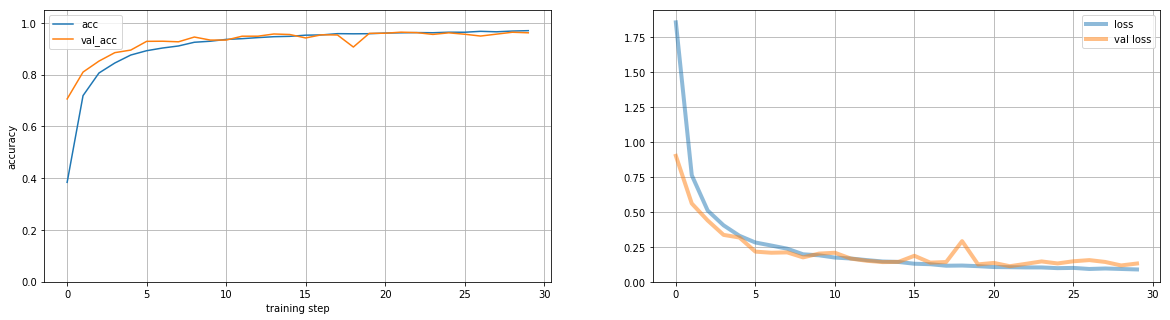

In [15]:
plot_metrics_model(model)

En las gráficas puede observarse que la precisión y la validación de la precisión son muy cercanas hasta el final del entrenamiento, terminando la precisión en un 97.02% y la validación en un 96.19%, los cuales son valores esperados de un modelo bien entrenado.

Por su parte, la pérdida muestra un comportamiento favorable, teniendo en cuenta que permanece decreciendo durante todo el entrenamiento junto a la validación de la pérdida, que tiende a estabilizarse a partir de la época 20.

En general, teniendo en cuenta estos resultados, decidimos quedarnos con este modelo y los que se presentan en U3.2.1 y U3.2.2. Estos modelos son puestos a prueba en la tarea de clasificación.

Finalmente, se guarda y se descarga el modelo de Colab junto con los pesos obtenidos a partir del entrenamiento:

In [0]:
from google.colab import files
model.save('./CNN_Test_Val.model')
files.download('./CNN_Test_Val.model')